In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Hopefully this is the right dataset; the book-provided links are broken

df = pd.read_csv("https://github.com/JohnMount/Penguins/blob/main/penguins_raw.csv?raw=true")
df.shape # Looks like it

(344, 17)

In [5]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [11]:
# There are 3 penguin species.
# 4 measures will be used to classify them

def make_cdf_map(df, colname, by="Species"):
    """Make a CDF for each species"""
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name=species)
    return cdf_map

In [8]:
from empiricaldist import Cdf

In [15]:
def plot_cdfs(df, colname, by="Species"):
    cdf_map = make_cdf_map(df, colname, by)
    
    for species, cdf in cdf_map.items():
        cdf.plot(label=species, marker='', xlabel=colname, ylabel="CDF")
        plt.legend()

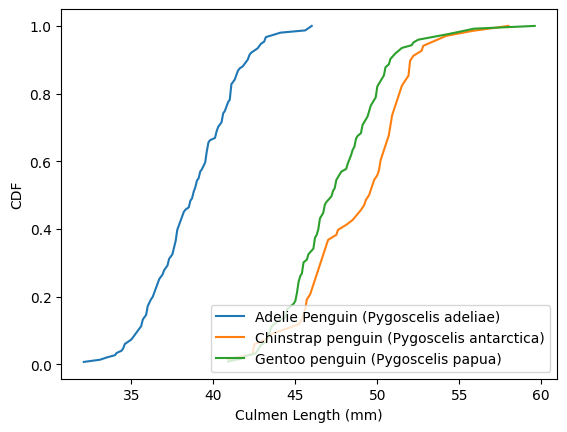

In [16]:
colname="Culmen Length (mm)"
plot_cdfs(df, colname) # Culmen length can be used to identify Adelie penguins, but not the other types

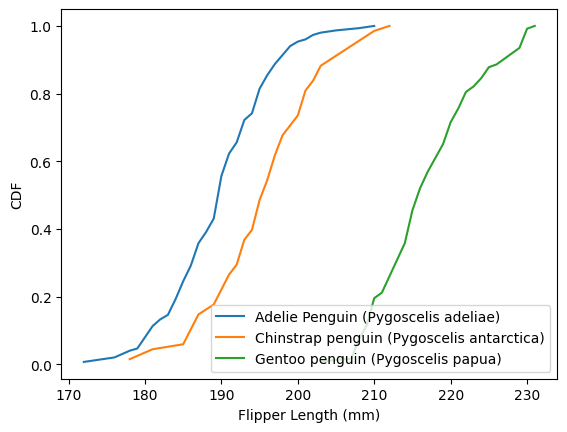

In [17]:
colname="Flipper Length (mm)"
plot_cdfs(df, colname) # Flipper length, however, can better distinguish Gentoo penguins

# The sigmoid shape of the CDFs is characteristic of the normal distribution, which we'll use

In [18]:
# Bayesian analysis
# 1. Define a prior with prior probabilities for each of the 3 species
# 2. Compute a likelihood of the data for each species - use data parameters to estimate params of a normal for each species
# 3. Compute the posterior for each hypothesis

from scipy.stats import norm

In [19]:
def make_norm_map(df, colname, by="Species"):
    norm_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = norm(mean, std)
    return norm_map

In [20]:
# For example, here's a dictionary of norm objects for flipped length

flipper_map = make_norm_map(df, "Flipper Length (mm)")
flipper_map.keys()

dict_keys(['Adelie Penguin (Pygoscelis adeliae)', 'Chinstrap penguin (Pygoscelis antarctica)', 'Gentoo penguin (Pygoscelis papua)'])

In [21]:
# Suppose we measure a penguin and find flipper length 193 mm. What is the probability of that data under each hypothesis?

data = 193

hypos = flipper_map.keys()
likelihood = [flipper_map[hypo].pdf(data) for hypo in hypos]
likelihood

[np.float64(0.054732511875530694),
 np.float64(0.05172135615888162),
 np.float64(5.8660453661990634e-05)]

In [22]:
# As usual, use Pmf to define the prior

from empiricaldist import Pmf

In [23]:
prior = Pmf(1/3, hypos)
prior

,probs
Adelie Penguin (Pygoscelis adeliae),0.333333
Chinstrap penguin (Pygoscelis antarctica),0.333333
Gentoo penguin (Pygoscelis papua),0.333333


In [24]:
posterior = prior * likelihood
posterior.normalize()
posterior # Flipper length 193 indicates a penguin is very unlikely to be a Gentoo, but equally likely to be one of the other types


,probs
Adelie Penguin (Pygoscelis adeliae),0.513860
Chinstrap penguin (Pygoscelis antarctica),0.485589
Gentoo penguin (Pygoscelis papua),0.000551


In [25]:
# Create a function to encapsulate these steps

def update_penguin(prior, data, norm_map):
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

In [27]:
# Flipper length doesn't differentiate well between Adelie and Chinstrap penguins, but culmen length can
# Do a second update with culmen length

culmen_map = make_norm_map(df, "Culmen Length (mm)")

# Suppose we see a penguin with culmen length 48 mm. Use this to update

posterior2 = update_penguin(prior, 48, culmen_map)
posterior2 # We can do a better job of classification with multiple features

,probs
Adelie Penguin (Pygoscelis adeliae),0.001557
Chinstrap penguin (Pygoscelis antarctica),0.474658
Gentoo penguin (Pygoscelis papua),0.523785


In [28]:
# Naive Bayes Classification

def update_naive(prior, data_seq, norm_maps):
    """Naive Bayes classifier
    
    prior: Pmf
    data_seq: sequence of measurements
    norm_maps: sequence of maps from species to distribution
    
    returns Pmf representing the posterior
    IOW this performs a series of updates 1 variable at a time
    """
    
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps):
        posterior = update_penguin(posterior, data, norm_map)
    return posterior

In [29]:
colnames = ["Flipper Length (mm)", "Culmen Length (mm)"]
norm_maps = [flipper_map, culmen_map]

data_seq = 193, 48

posterior = update_naive(prior, data_seq, norm_maps)
posterior

,probs
Adelie Penguin (Pygoscelis adeliae),0.003455
Chinstrap penguin (Pygoscelis antarctica),0.995299
Gentoo penguin (Pygoscelis papua),0.001246


In [30]:
posterior.max_prob()

'Chinstrap penguin (Pygoscelis antarctica)'

In [31]:
# We can loop through the dataset and classify every penguin with these 2 features

df["Classification"] = np.nan

for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, "Classification"] = posterior.max_prob()

/tmp/ipykernel_3139/1478566409.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Adelie Penguin (Pygoscelis adeliae)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, "Classification"] = posterior.max_prob()
/home/nemptage/thinkbayes/lib/python3.11/site-packages/empiricaldist/empiricaldist.py:559: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return self.idxmax(**kwargs)
/home/nemptage/thinkbayes/lib/python3.11/site-packages/empiricaldist/empiricaldist.py:559: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return self.idxmax(**kwargs)


In [32]:
# How accurate is this classification?

valid = df["Classification"].notna()
valid.sum()

np.int64(342)

In [33]:
same = df["Species"] == df["Classification"]
same.sum()

np.int64(324)

In [34]:
same.sum() / valid.sum() # so this classification is almost 95% accurate

np.float64(0.9473684210526315)

In [35]:
# A function to encapsulate these steps

def accuracy(df):
    valid = df["Classification"].notna()
    same = df["Species"] == df["Classification"]
    return same.sum() / valid.sum()

In [48]:
# This classification is called naive because it ignores correlations between the features
# We can make a less naive classifier that takes the joint distribution into account

# Start by making a scatterplot of the data

def scatterplot(df, var1, var2):
    grouped = df.groupby("Species")
    for species, group in grouped:
        plt.scatter(group[var1], group[var2], label=species)
        plt.xlabel(var1)
        plt.ylabel(var2)
        plt.legend()

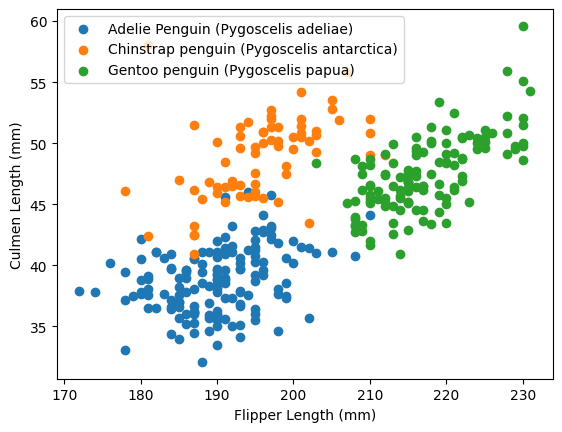

In [49]:
var1 = "Flipper Length (mm)"
var2 = "Culmen Length (mm)"

scatterplot(df, var1, var2)

In [50]:
# Within each species the joint distribution is oval-shaped, 
# and the ovals are along a diagonal, which suggests a correlation between the 2 features

# This function makes a discrete Pmf approximating a normal

def make_pmf_norm(dist, sigmas=3, n=101):
    mean, std = dist.mean(), dist.std()
    low = mean - sigmas * std
    high = mean + sigmas * std
    qs = np.linspace(low, high, n)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [51]:
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

In [52]:
joint_map = {}
for species in hypos:
    pmf1 = make_pmf_norm(flipper_map[species])
    pmf2 = make_pmf_norm(culmen_map[species])
    joint_map[species] = make_joint(pmf1, pmf2)

In [53]:
def plot_contour(joint):
    """Plot a joint distribution with a contour."""
    plt.contour(joint.columns, joint.index, joint,
                linewidths=2)

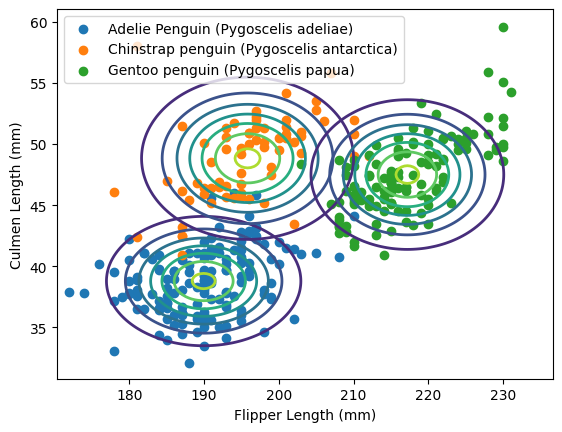

In [56]:
scatterplot(df, var1, var2)
for species in hypos:
    plot_contour(joint_map[species])
    
# The contours form ellipses. In this example, the ellipses are aligned with the axes because the features are 
# uncorrelated. But they don't align well with the data.

In [57]:
# A multivariate normal is characterized by the means of the features and the covariance matrix
# These can be estimated from the data

features = df[[var1, var2]]

mean = features.mean()
mean

Flipper Length (mm)    200.915205
Culmen Length (mm)      43.921930
dtype: float64

In [58]:
cov = features.cov()
cov

,Flipper Length (mm),Culmen Length (mm)
Flipper Length (mm),197.731792,50.375765
Culmen Length (mm),50.375765,29.807054


In [59]:
from scipy.stats import multivariate_normal

In [60]:
multinorm = multivariate_normal(mean, cov)

In [61]:
# This function makes a multivariate_normal object for each species

def make_multinorm_map(df, colnames):
    """Map from each species to a multivariate normal"""
    multinorm_map = {}
    grouped = df.groupby("Species")
    for species, group in grouped:
        features = group[colnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = multivariate_normal(mean, cov)
    return multinorm_map

In [62]:
multinorm_map = make_multinorm_map(df, [var1, var2])

In [63]:
# visualizing this takes some work

norm1 = flipper_map["Adelie Penguin (Pygoscelis adeliae)"]
norm2 = culmen_map["Adelie Penguin (Pygoscelis adeliae)"]
multinorm = multinorm_map["Adelie Penguin (Pygoscelis adeliae)"]

# Make discrete Pmf for each univariate normal

pmf1 = make_pmf_norm(norm1)
pmf2 = make_pmf_norm(norm2)

X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
X.shape

(101, 101)

In [65]:
# To evaluate the multivariate distribution for each pair of values, we have to stack the arrays

pos = np.dstack((X, Y))
pos.shape

(101, 101, 2)

In [66]:
# pos is a 2D array of pairs, when passed to multinorm.pdf it evaluates the pdf for each pair

densities = multinorm.pdf(pos)
densities.shape

(101, 101)

In [67]:
def normalize(joint):
    """Normalize a joint distribution."""
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

In [68]:
joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
normalize(joint)

np.float64(15.871343639913828)

In [70]:
# Alt version of make_joint that takes 3 arguments

def make_joint(norm1, norm2, multinorm):
    """Make a joint distribution.
    
    norm1: `norm` object representing the distribution of the first feature
    norm2: `norm` object representing the distribution of the second feature
    multinorm: `multivariate_normal` object representing the joint distribution
    """
    pmf1 = make_pmf_norm(norm1)
    pmf2 = make_pmf_norm(norm2)
    X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
    pos = np.dstack((X, Y))
    densities = multinorm.pdf(pos)
    joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
    return joint

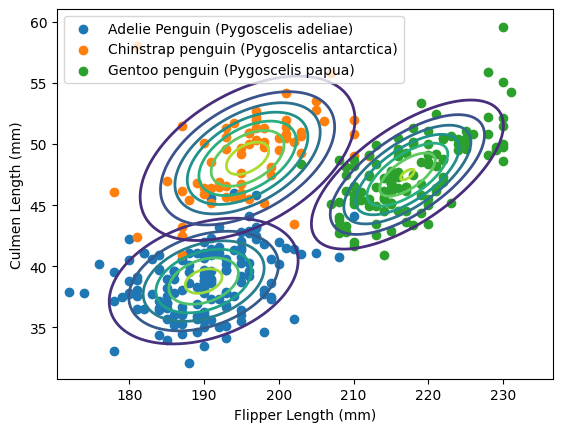

In [71]:
scatterplot(df, var1, var2)

for species in hypos:
    norm1 = flipper_map[species]
    norm2 = culmen_map[species]
    multinorm = multinorm_map[species]
    joint = make_joint(norm1, norm2, multinorm)
    plot_contour(joint)

In [72]:
# So, a less naive classifier

data = 193, 48

update_penguin(prior, data, multinorm_map)

,probs
Adelie Penguin (Pygoscelis adeliae),0.002740
Chinstrap penguin (Pygoscelis antarctica),0.997257
Gentoo penguin (Pygoscelis papua),0.000003


In [73]:
# Is this better than the naive Bayes classifier? Let's apply to every penguin in the dataset

df["Classification"] = np.nan

for i, row in df.iterrows():
    data = row[colnames]
    posterior = update_penguin(prior, data, multinorm_map)
    df.loc[i, "Classification"] = posterior.idxmax()

/tmp/ipykernel_3139/285977064.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Adelie Penguin (Pygoscelis adeliae)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, "Classification"] = posterior.idxmax()
/tmp/ipykernel_3139/285977064.py:8: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df.loc[i, "Classification"] = posterior.idxmax()
/tmp/ipykernel_3139/285977064.py:8: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df.loc[i, "Classification"] = posterior.idxmax()


In [74]:
accuracy(df) # so a very small improvement on the naive classifier

np.float64(0.9532163742690059)

In [75]:
# Exercise 12-1 - make a naive classifier that uses all 4 of flipper length, culmen length, culmen depth, body mass

# Apply make_norm_map for the other 2 features:

culmend_map = make_norm_map(df, "Culmen Depth (mm)")
bm_map = make_norm_map(df, "Body Mass (g)")

colnames = ["Flipper Length (mm)", "Culmen Length (mm)", "Culmen Depth (mm)", "Body Mass (g)"]
norm_maps = [flipper_map, culmen_map, culmend_map, bm_map]

data_seq = 193, 48

posterior = update_naive(prior, data_seq, norm_maps)
posterior

,probs
Adelie Penguin (Pygoscelis adeliae),0.003455
Chinstrap penguin (Pygoscelis antarctica),0.995299
Gentoo penguin (Pygoscelis papua),0.001246


In [76]:
df["Classification"] = np.nan

for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, "Classification"] = posterior.max_prob()

/tmp/ipykernel_3139/3361133850.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Adelie Penguin (Pygoscelis adeliae)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, "Classification"] = posterior.max_prob()
/home/nemptage/thinkbayes/lib/python3.11/site-packages/empiricaldist/empiricaldist.py:559: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return self.idxmax(**kwargs)
/home/nemptage/thinkbayes/lib/python3.11/site-packages/empiricaldist/empiricaldist.py:559: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return self.idxmax(**kwargs)


In [77]:
accuracy(df) # Somewhat more accurate, but THIS IS RIGHT!!!

np.float64(0.9678362573099415)

In [79]:
# Exercise 12-2
# Create a sub-dataset of just 1 penguin species

gentoo = df.loc[df["Species"] == "Gentoo penguin (Pygoscelis papua)"]

# Use the same 4 features to classify sex: essentially repeat the exercises of the chapter

In [80]:
gentoo.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments,Classification
152,PAL0708,1,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N31A1,Yes,2007-11-27,46.1,13.2,211.0,4500.0,FEMALE,7.99300,-25.51390,NaN,Gentoo penguin (Pygoscelis papua)
153,PAL0708,2,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N31A2,Yes,2007-11-27,50.0,16.3,230.0,5700.0,MALE,8.14756,-25.39369,NaN,Gentoo penguin (Pygoscelis papua)
154,PAL0708,3,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A1,Yes,2007-11-27,48.7,14.1,210.0,4450.0,FEMALE,8.14705,-25.46172,NaN,Gentoo penguin (Pygoscelis papua)
155,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,2007-11-27,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN,Gentoo penguin (Pygoscelis papua)
156,PAL0708,5,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N33A1,Yes,2007-11-18,47.6,14.5,215.0,5400.0,MALE,8.23450,-25.54456,NaN,Gentoo penguin (Pygoscelis papua)


In [81]:
gentoo.shape

(124, 18)

In [82]:
def make_sexcdf_map(df, colname, by="Sex"):
    """Make a CDF for each sex"""
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for sex, group in grouped:
        cdf_map[sex] = Cdf.from_seq(group, name=sex)
    return cdf_map

In [83]:
def plot_sexcdfs(df, colname, by="Sex"):
    cdf_map = make_sexcdf_map(df, colname, by)
    
    for sex, cdf in cdf_map.items():
        cdf.plot(label=sex, marker='', xlabel=colname, ylabel="CDF")
        plt.legend()

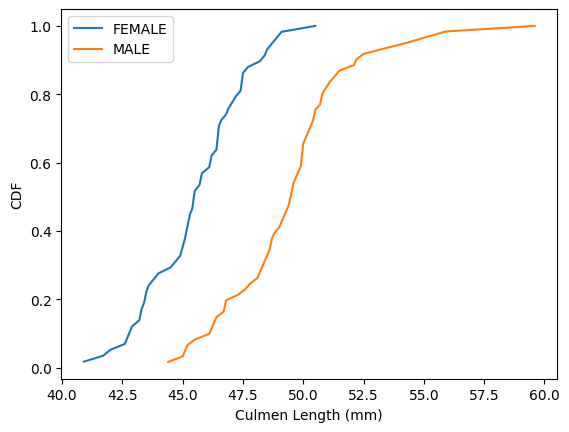

In [94]:
colname="Culmen Length (mm)"
plot_sexcdfs(gentoo, colname)

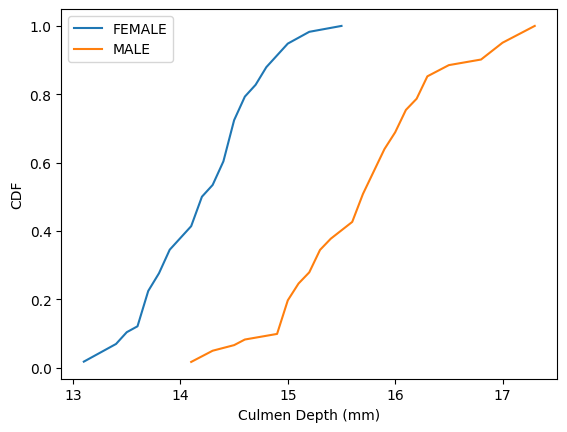

In [95]:
colname="Culmen Depth (mm)"
plot_sexcdfs(gentoo, colname)

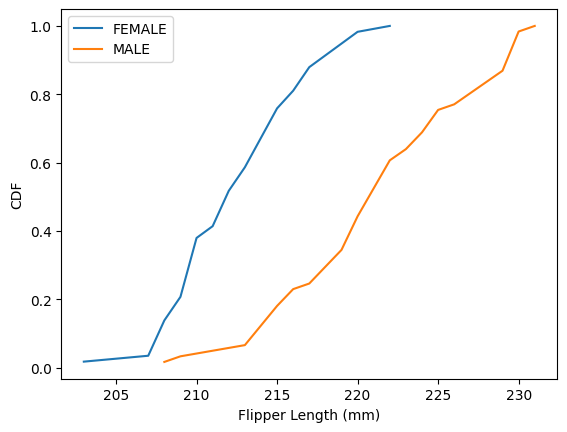

In [96]:
colname="Flipper Length (mm)"
plot_sexcdfs(gentoo, colname)

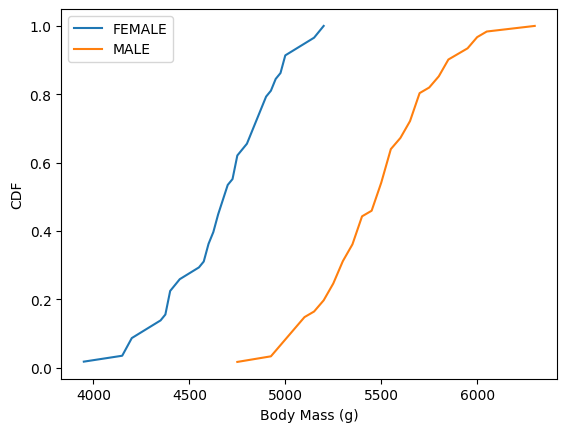

In [97]:
colname="Body Mass (g)"
plot_sexcdfs(gentoo, colname)

In [88]:
def make_sexnorm_map(df, colname, by="Sex"):
    norm_map = {}
    grouped = df.groupby(by)[colname]
    for sex, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[sex] = norm(mean, std)
    return norm_map

In [106]:
flipper_sex_map = make_sexnorm_map(gentoo, "Flipper Length (mm)")
flipper_sex_map.keys()

dict_keys(['FEMALE', 'MALE'])

In [99]:
culmenl_sex_map = make_sexnorm_map(gentoo, "Culmen Length (mm)")
culmenl_sex_map.keys()

dict_keys(['FEMALE', 'MALE'])

In [100]:
culmend_sex_map = make_sexnorm_map(gentoo, "Culmen Depth (mm)")
culmend_sex_map.keys()

dict_keys(['FEMALE', 'MALE'])

In [101]:
bm_sex_map = make_sexnorm_map(gentoo, "Body Mass (g)")
bm_sex_map.keys()

dict_keys(['FEMALE', 'MALE'])

In [107]:
hypos_sex = flipper_sex_map.keys()

prior = Pmf(1/2, hypos_sex)
prior

,probs
FEMALE,0.5
MALE,0.5


In [108]:
# Should be able to just update using the same naive classifier function

colnames = ["Flipper Length (mm)", "Culmen Length (mm)", "Culmen Depth (mm)", "Body Mass (g)"]
norm_maps = [flipper_sex_map, culmenl_sex_map, culmend_sex_map, bm_sex_map]

sex_posterior = update_naive(prior, data_seq, norm_maps)
sex_posterior

,probs
FEMALE,9.069525e-08
MALE,9.999999e-01


In [111]:
sex_posterior.max_prob()

'MALE'

In [112]:
gentoo["Classification"] = np.nan

for i, row in gentoo.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    gentoo.loc[i, "Classification"] = posterior.max_prob()

/tmp/ipykernel_3139/682363557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gentoo["Classification"] = np.nan
/tmp/ipykernel_3139/682363557.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'FEMALE' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  gentoo.loc[i, "Classification"] = posterior.max_prob()
/home/nemptage/thinkbayes/lib/python3.11/site-packages/empiricaldist/empiricaldist.py:559: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return self.idxmax(**kwargs)


In [113]:
valid = gentoo["Classification"].notna()
valid.sum()

np.int64(123)

In [114]:
same = gentoo["Sex"] == gentoo["Classification"]
same.sum()

np.int64(113)

In [115]:
same.sum() / valid.sum() # THIS IS RIGHT!

np.float64(0.9186991869918699)

In [116]:
# If we make this a less naive classifier

def make_multinorm_sex_map(df, colnames):
    """Map from each species to a multivariate normal"""
    multinorm_map = {}
    grouped = df.groupby("Sex")
    for sex, group in grouped:
        features = group[colnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[sex] = multivariate_normal(mean, cov)
    return multinorm_map

In [117]:
var1 = "Flipper Length (mm)"
var2 = "Culmen Length (mm)"
var3 = "Culmen Depth (mm)"
var4 = "Body Mass (g)"

multinorm_sex_map = make_multinorm_sex_map(gentoo, [var1, var2, var3, var4])

In [119]:
update_penguin(prior, data, multinorm_sex_map) # Not sure why this throws an error, but I think I'm done

ValueError: operands could not be broadcast together with shapes (1,2) (4,) 